## Exploratory Data Analysis
### Check Correlations and Predicted vs Actual PPR Fantasy Points


In [2]:
import pandas as pd
import numpy as np
from scipy import stats

#try using plotly for graphing - should help transition to later javascript graphs
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
#need to use Plotly API Key in order to get it to run
plotly.tools.set_credentials_file(username='mtsuomi', api_key='KU6JDtNccJICaVmeF2gF')

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base

In [3]:
#create engine to the database
db_fantasy_football_2018 = create_engine('sqlite:///../fantasy_football_2018.db')

#create inspector so can see schema of database visually
inspector = inspect(db_fantasy_football_2018)

#Database Schema - verify the database has the info we are expecting by printing out all the schema visually
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print(table_name, column.get('name'), column.get('type'))
    print()

#other options for using SQLAlchemy sort of coding instead of traditional SQL queries
# engine = create_engine('sqlite:///raw_data/hawaii.sqlite')
# Base = automap_base()
# Base.prepare(engine, reflect=True)
# session = Session(bind=engine)
# inspector = inspect(engine)

week1_ppr_actuals PLAYER TEXT
week1_ppr_actuals POS TEXT
week1_ppr_actuals TEAM TEXT
week1_ppr_actuals FPTS_PPR_ACTUAL FLOAT
week1_ppr_actuals WEEK BIGINT

week1_ppr_projections PLAYER TEXT
week1_ppr_projections POS TEXT
week1_ppr_projections TEAM TEXT
week1_ppr_projections FPTS_PPR_ESPN FLOAT
week1_ppr_projections FPTS_PPR_CBS FLOAT
week1_ppr_projections FPTS_PPR_SHARKS FLOAT
week1_ppr_projections FPTS_PPR_SCOUT FLOAT
week1_ppr_projections FPTS_PPR_PRVS_WK_ACTUAL FLOAT

week1_ppr_projections_all_scraped PLAYER TEXT
week1_ppr_projections_all_scraped POS TEXT
week1_ppr_projections_all_scraped TEAM TEXT
week1_ppr_projections_all_scraped FPTS_PPR_ESPN FLOAT
week1_ppr_projections_all_scraped FPTS_PPR_CBS FLOAT
week1_ppr_projections_all_scraped FPTS_PPR_SHARKS FLOAT
week1_ppr_projections_all_scraped FPTS_PPR_SCOUT FLOAT
week1_ppr_projections_all_scraped FPTS_PPR_PRVS_WK_ACTUAL FLOAT

week1_salaries_fanduel PLAYER TEXT
week1_salaries_fanduel POS TEXT
week1_salaries_fanduel TEAM TEXT
week1_sa

### Week 1 Actual vs Predicted

In [4]:
#get week 1 projections
stmt = """
        SELECT *
        FROM week1_ppr_projections
       """

df_week1_ppr_projections = pd.read_sql_query(stmt, db_fantasy_football_2018)
print(df_week1_ppr_projections.shape)
df_week1_ppr_projections.head()

(358, 8)


,PLAYER,POS,TEAM,FPTS_PPR_ESPN,FPTS_PPR_CBS,FPTS_PPR_SHARKS,FPTS_PPR_SCOUT,FPTS_PPR_PRVS_WK_ACTUAL
0,Alvin Kamara,RB,NO,22.2,19.0,19.1,34.0,0.0
1,David Johnson,RB,Ari,21.3,19.0,23.6,27.0,0.0
2,Todd Gurley,RB,LAR,21.2,23.0,19.3,28.5,0.0
3,Antonio Brown,WR,Pit,19.5,22.0,19.3,17.3,0.0
4,Tom Brady,QB,NE,19.4,20.0,27.4,23.3,0.0


In [5]:
#get week 1 actuals
stmt = """
        SELECT *
        FROM week1_ppr_actuals
       """

df_week1_ppr_actuals = pd.read_sql_query(stmt, db_fantasy_football_2018)
print(df_week1_ppr_actuals.shape)
df_week1_ppr_actuals.head()

(1007, 5)


,PLAYER,POS,TEAM,FPTS_PPR_ACTUAL,WEEK
0,Alvin Kamara,RB,NO,43.1,1
1,Ryan Fitzpatrick,QB,TB,42.3,1
2,Tyreek Hill,WR,KC,42.3,1
3,Michael Thomas,WR,NO,38.0,1
4,James Conner,RB,Pit,34.2,1


In [6]:
df_week1_ppr_projections.columns

Index(['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
       'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL'],
      dtype='object')

In [7]:
#merge starting with the actuals db and merge inner (don't want to evaluate correlations of players not in db)
df_week1_ppr = pd.merge(df_week1_ppr_actuals, df_week1_ppr_projections[['PLAYER', 'POS',
                                                'FPTS_PPR_ESPN', 'FPTS_PPR_CBS', 'FPTS_PPR_SHARKS',
                                                'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']],
                        how='inner', on=['PLAYER', 'POS'])

print(df_week1_ppr.shape)
df_week1_ppr.head()

(358, 10)


,PLAYER,POS,TEAM,FPTS_PPR_ACTUAL,WEEK,FPTS_PPR_ESPN,FPTS_PPR_CBS,FPTS_PPR_SHARKS,FPTS_PPR_SCOUT,FPTS_PPR_PRVS_WK_ACTUAL
0,Alvin Kamara,RB,NO,43.1,1,22.2,19.0,19.1,34.0,0.0
1,Ryan Fitzpatrick,QB,TB,42.3,1,15.7,14.0,15.5,23.4,0.0
2,Tyreek Hill,WR,KC,42.3,1,14.5,14.0,14.0,17.6,0.0
3,Michael Thomas,WR,NO,38.0,1,17.9,21.0,19.1,18.6,0.0
4,James Conner,RB,Pit,34.2,1,12.9,10.0,19.4,17.7,0.0


In [8]:
df_week1_ppr.columns

Index(['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 'FPTS_PPR_ESPN',
       'FPTS_PPR_CBS', 'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT',
       'FPTS_PPR_PRVS_WK_ACTUAL'],
      dtype='object')

##### Add an Average Projection column that averages all four projections

In [9]:
#average all four of our projection sources of ESPN, CBS, Sharks, and Scout
df_week1_ppr['FPTS_PPR_AVG_PROJ'] = df_week1_ppr[['FPTS_PPR_ESPN','FPTS_PPR_CBS',
                                                  'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT']].mean(axis='columns')
df_week1_ppr.head()

,PLAYER,POS,TEAM,FPTS_PPR_ACTUAL,WEEK,FPTS_PPR_ESPN,FPTS_PPR_CBS,FPTS_PPR_SHARKS,FPTS_PPR_SCOUT,FPTS_PPR_PRVS_WK_ACTUAL,FPTS_PPR_AVG_PROJ
0,Alvin Kamara,RB,NO,43.1,1,22.2,19.0,19.1,34.0,0.0,23.575
1,Ryan Fitzpatrick,QB,TB,42.3,1,15.7,14.0,15.5,23.4,0.0,17.150
2,Tyreek Hill,WR,KC,42.3,1,14.5,14.0,14.0,17.6,0.0,15.025
3,Michael Thomas,WR,NO,38.0,1,17.9,21.0,19.1,18.6,0.0,19.150
4,James Conner,RB,Pit,34.2,1,12.9,10.0,19.4,17.7,0.0,15.000


### Scatter Plots of Actual PPR vs. Projections
Graph scatter plot and linear regression line
- slopes above 1.0 typically are underprojecting points
- slopes below 1.0 typically are overprojecting points

In [10]:
y_actual_ppr = df_week1_ppr['FPTS_PPR_ACTUAL']

In [11]:
### ESPN CORRELATIONS TO ACTUAL ###
x_espn_ppr = df_week1_ppr['FPTS_PPR_ESPN']

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x_espn_ppr, y_actual_ppr)
print(f"""Week 1 ESPN Projection to Actual PPRs: \n
        Slope = {slope} \n
        Correlation R-Value = {r_value} \n
        R^2= {r_value**2} \n
        p_value = {p_value} \n\n""")
line_best_fit = slope*x_espn_ppr + intercept

#create a trace of scatter data
trace_espn = go.Scatter(
        x = x_espn_ppr,
        y = y_actual_ppr,
        mode = 'markers',
        marker=go.scatter.Marker(color='rgb(255, 127, 14)'),
        name = 'data'
        )

#create a trace of line_best_fit data
trace_line_best_fit = go.Scatter(
        x = x_espn_ppr,
        y = line_best_fit,
        mode = 'lines',
        marker=go.scatter.Marker(color='rgb(31, 119, 180)'),
        name = 'fit'
        )

#create annotation for graph
annotation = go.layout.Annotation(
#                   x=3.5,
#                   y=23.5,
                  text=f"$R^2 = {r_value ** 2}",
                  showarrow=False,
#                   font=go.layout.Font({'size':12})
                  )

# #create layout options
# layout = go.Layout(
#             title = 'Week 1 Actual PPRs vs ESPN Projections',
#             plot_bgcolor='rgb(229, 229, 229)',
#             xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             annotations=[annotation]
#             )

#store all data as list of traces
data_espn = [trace_espn, trace_line_best_fit]


# Plot and embed in ipython notebook!
py.iplot(data_espn, filename='wk1_espn')
# py.iplot(data_espn, layout=layout, filename='wk1_espn')

# #other way to plot figure (not in jupyter)
# fig = go.Figure(data=data_espn, layout=layout)
# py.plot(fig, filename='wk1_espn')

Week 1 ESPN Projection to Actual PPRs: 

        Slope = 1.0751643571344256 

        Correlation R-Value = 0.5978406288296402 

        R^2= 0.35741341747941957 

        p_value = 4.560415614604207e-36 




In [12]:
### CBS CORRELATIONS TO ACTUAL ###
x_cbs_ppr = df_week1_ppr['FPTS_PPR_CBS']

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x_cbs_ppr, y_actual_ppr)
print(f"""Week 1 CBS Projection to Actual PPRs: \n
        Slope = {slope} \n
        Correlation R-Value = {r_value} \n
        R^2 = {r_value**2} \n
        p_value = {p_value} \n\n""")
line_best_fit = slope*x_cbs_ppr + intercept

#create a trace of scatter data
trace_cbs = go.Scatter(
        x = x_cbs_ppr,
        y = y_actual_ppr,
        mode = 'markers',
        marker=go.scatter.Marker(color='rgb(255, 127, 14)'),
        name = 'data'
        )

#create a trace of line_best_fit data
trace_line_best_fit = go.Scatter(
        x = x_cbs_ppr,
        y = line_best_fit,
        mode = 'lines',
        marker=go.scatter.Marker(color='rgb(31, 119, 180)'),
        name = 'fit'
        )

#create annotation for graph
annotation = go.layout.Annotation(
#                   x=3.5,
#                   y=23.5,
                  text=f"$R^2 = {r_value ** 2}",
                  showarrow=False,
#                   font=go.layout.Font({'size':12})
                  )

# #create layout options
# layout = go.Layout(
#             title = 'Week 1 Actual PPRs vs cbs Projections',
#             plot_bgcolor='rgb(229, 229, 229)',
#             xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             annotations=[annotation]
#             )

#store all data as list of traces
data_cbs = [trace_cbs, trace_line_best_fit]


# Plot and embed in ipython notebook!
py.iplot(data_cbs, filename='wk1_cbs')
# py.iplot(data_cbs, layout=layout, filename='wk1_cbs')

# #other way to plot figure (not in jupyter)
# fig = go.Figure(data=data_cbs, layout=layout)
# py.plot(fig, filename='wk1_cbs')

Week 1 CBS Projection to Actual PPRs: 

        Slope = 0.9860107756357791 

        Correlation R-Value = 0.5789523735730286 

        R^2 = 0.33518585086584374 

        p_value = 2.0023434283698823e-33 




In [13]:
### SHARKS CORRELATIONS TO ACTUAL ###
x_sharks_ppr = df_week1_ppr['FPTS_PPR_SHARKS']

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x_sharks_ppr, y_actual_ppr)
print(f"""Week 1 Sharks Projection to Actual PPRs: \n
        Slope = {slope} \n
        Correlation R-Value = {r_value} \n
        R^2= {r_value**2} \n
        p_value = {p_value} \n\n""")
line_best_fit = slope*x_sharks_ppr + intercept

#create a trace of scatter data
trace_sharks = go.Scatter(
        x = x_sharks_ppr,
        y = y_actual_ppr,
        mode = 'markers',
        marker=go.scatter.Marker(color='rgb(255, 127, 14)'),
        name = 'data'
        )

#create a trace of line_best_fit data
trace_line_best_fit = go.Scatter(
        x = x_sharks_ppr,
        y = line_best_fit,
        mode = 'lines',
        marker=go.scatter.Marker(color='rgb(31, 119, 180)'),
        name = 'fit'
        )

#create annotation for graph
annotation = go.layout.Annotation(
#                   x=3.5,
#                   y=23.5,
                  text=f"$R^2 = {r_value ** 2}",
                  showarrow=False,
#                   font=go.layout.Font({'size':12})
                  )

# #create layout options
# layout = go.Layout(
#             title = 'Week 1 Actual PPRs vs sharks Projections',
#             plot_bgcolor='rgb(229, 229, 229)',
#             xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             annotations=[annotation]
#             )

#store all data as list of traces
data_sharks = [trace_sharks, trace_line_best_fit]


# Plot and embed in ipython notebook!
py.iplot(data_sharks, filename='wk1_sharks')
# py.iplot(data_sharks, layout=layout, filename='wk1_sharks')

# #other way to plot figure (not in jupyter)
# fig = go.Figure(data=data_sharks, layout=layout)
# py.plot(fig, filename='wk1_sharks')

Week 1 Sharks Projection to Actual PPRs: 

        Slope = 0.8718295026201288 

        Correlation R-Value = 0.5516810431604505 

        R^2= 0.3043519733826029 

        p_value = 6.711709152888953e-30 




In [14]:
### SCOUT CORRELATIONS TO ACTUAL ###
x_scout_ppr = df_week1_ppr['FPTS_PPR_SCOUT']

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x_scout_ppr, y_actual_ppr)
print(f"""Week 1 Scout Projection to Actual PPRs: \n
        Slope = {slope} \n
        Correlation R-Value = {r_value} \n
        R^2= {r_value**2} \n
        p_value = {p_value} \n\n""")
line_best_fit = slope*x_scout_ppr + intercept

#create a trace of scatter data
trace_scout = go.Scatter(
        x = x_scout_ppr,
        y = y_actual_ppr,
        mode = 'markers',
        marker=go.scatter.Marker(color='rgb(255, 127, 14)'),
        name = 'data'
        )

#create a trace of line_best_fit data
trace_line_best_fit = go.Scatter(
        x = x_scout_ppr,
        y = line_best_fit,
        mode = 'lines',
        marker=go.scatter.Marker(color='rgb(31, 119, 180)'),
        name = 'fit'
        )

#create annotation for graph
annotation = go.layout.Annotation(
#                   x=3.5,
#                   y=23.5,
                  text=f"$R^2 = {r_value ** 2}",
                  showarrow=False,
#                   font=go.layout.Font({'size':12})
                  )

# #create layout options
# layout = go.Layout(
#             title = 'Week 1 Actual PPRs vs scout Projections',
#             plot_bgcolor='rgb(229, 229, 229)',
#             xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             annotations=[annotation]
#             )

#store all data as list of traces
data_scout = [trace_scout, trace_line_best_fit]


# Plot and embed in ipython notebook!
py.iplot(data_scout, filename='wk1_scout')
# py.iplot(data_scout, layout=layout, filename='wk1_scout')

# #other way to plot figure (not in jupyter)
# fig = go.Figure(data=data_scout, layout=layout)
# py.plot(fig, filename='wk1_scout')

Week 1 Scout Projection to Actual PPRs: 

        Slope = 0.7854477039970628 

        Correlation R-Value = 0.5840197827895562 

        R^2= 0.34107910668956043 

        p_value = 4.069051005306131e-34 




In [15]:
### AVERAGE OF ALL FOUR PROJECTIONS CORRELATIONS TO ACTUAL ###
x_avg_proj_ppr = df_week1_ppr['FPTS_PPR_AVG_PROJ']

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x_espn_ppr, y_actual_ppr)
print(f"""Week 1 Average of all Four Projections to Actual PPRs: \n
        Slope = {slope} \n
        Correlation R-Value = {r_value} \n
        R^2= {r_value**2} \n
        p_value = {p_value} \n\n""")
line_best_fit = slope*x_avg_proj_ppr + intercept

#create a trace of scatter data
trace_avg_proj = go.Scatter(
        x = x_avg_proj_ppr,
        y = y_actual_ppr,
        mode = 'markers',
        marker=go.scatter.Marker(color='rgb(255, 127, 14)'),
        name = 'data'
        )

#create a trace of line_best_fit data
trace_line_best_fit = go.Scatter(
        x = x_avg_proj_ppr,
        y = line_best_fit,
        mode = 'lines',
        marker=go.scatter.Marker(color='rgb(31, 119, 180)'),
        name = 'fit'
        )

#create annotation for graph
annotation = go.layout.Annotation(
#                   x=3.5,
#                   y=23.5,
                  text=f"$R^2 = {r_value ** 2}",
                  showarrow=False,
#                   font=go.layout.Font({'size':12})
                  )

# #create layout options
# layout = go.Layout(
#             title = 'Week 1 Actual PPRs vs ESPN Projections',
#             plot_bgcolor='rgb(229, 229, 229)',
#             xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             annotations=[annotation]
#             )

#store all data as list of traces
data_avg_proj = [trace_avg_proj, trace_line_best_fit]


# Plot and embed in ipython notebook!
py.iplot(data_avg_proj, filename='wk1_avg_proj')
# py.iplot(data_espn, layout=layout, filename='wk1_espn')

# #other way to plot figure (not in jupyter)
# fig = go.Figure(data=data_espn, layout=layout)
# py.plot(fig, filename='wk1_espn')

Week 1 Average of all Four Projections to Actual PPRs: 

        Slope = 1.0751643571344256 

        Correlation R-Value = 0.5978406288296402 

        R^2= 0.35741341747941957 

        p_value = 4.560415614604207e-36 




In [16]:
### PREVIOUS WEEK TO ACTUAL ###
x_prvs_wk_ppr = df_week1_ppr['FPTS_PPR_PRVS_WK_ACTUAL']

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(x_scout_ppr, y_actual_ppr)
print(f"""Week 1 Previous Week Actual Projection to Actual PPRs: \n
        Slope = {slope} \n
        Correlation R-Value = {r_value} \n
        R^2= {r_value**2} \n
        p_value = {p_value} \n\n""")
line_best_fit = slope*x_prvs_wk_ppr + intercept

#create a trace of scatter data
trace_prvs_wk = go.Scatter(
        x = x_prvs_wk_ppr,
        y = y_actual_ppr,
        mode = 'markers',
        marker=go.scatter.Marker(color='rgb(255, 127, 14)'),
        name = 'data'
        )

#create a trace of line_best_fit data
trace_line_best_fit = go.Scatter(
        x = x_prvs_wk_ppr,
        y = line_best_fit,
        mode = 'lines',
        marker=go.scatter.Marker(color='rgb(31, 119, 180)'),
        name = 'fit'
        )

#create annotation for graph
annotation = go.layout.Annotation(
#                   x=3.5,
#                   y=23.5,
                  text=f"$R^2 = {r_value ** 2}",
                  showarrow=False,
#                   font=go.layout.Font({'size':12})
                  )

# #create layout options
# layout = go.Layout(
#             title = 'Week 1 Actual PPRs vs scout Projections',
#             plot_bgcolor='rgb(229, 229, 229)',
#             xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'),
#             annotations=[annotation]
#             )

#store all data as list of traces
data_prvs_wk = [trace_prvs_wk, trace_line_best_fit]


# Plot and embed in ipython notebook!
py.iplot(data_prvs_wk, filename='wk1_prvs_wk')
# py.iplot(data_scout, layout=layout, filename='wk1_scout')

# #other way to plot figure (not in jupyter)
# fig = go.Figure(data=data_scout, layout=layout)
# py.plot(fig, filename='wk1_scout')

Week 1 Previous Week Actual Projection to Actual PPRs: 

        Slope = 0.7854477039970628 

        Correlation R-Value = 0.5840197827895562 

        R^2= 0.34107910668956043 

        p_value = 4.069051005306131e-34 




### Investigate Differences of Proj vs Actual to Find Most Overrated and Underrated Players

In [17]:
df_week1_ppr.columns

Index(['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 'FPTS_PPR_ESPN',
       'FPTS_PPR_CBS', 'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT',
       'FPTS_PPR_PRVS_WK_ACTUAL', 'FPTS_PPR_AVG_PROJ'],
      dtype='object')

In [18]:
#calculate all the individual differences from projections
df_week1_ppr['DIFF_ESPN'] = df_week1_ppr['FPTS_PPR_ACTUAL'] - df_week1_ppr['FPTS_PPR_ESPN']
df_week1_ppr['DIFF_CBS'] = df_week1_ppr['FPTS_PPR_ACTUAL'] - df_week1_ppr['FPTS_PPR_CBS']
df_week1_ppr['DIFF_SHARKS'] = df_week1_ppr['FPTS_PPR_ACTUAL'] - df_week1_ppr['FPTS_PPR_SHARKS']
df_week1_ppr['DIFF_SCOUT'] = df_week1_ppr['FPTS_PPR_ACTUAL'] - df_week1_ppr['FPTS_PPR_SCOUT']
df_week1_ppr['DIFF_AVG_PROJ'] = df_week1_ppr['FPTS_PPR_ACTUAL'] - df_week1_ppr['FPTS_PPR_AVG_PROJ']
# df_week1_ppr['DIFF_PRVS_WK_ACTUAL'] = df_week1_ppr['FPTS_PPR_ACTUAL'] - df_week1_ppr['FPTS_PPR_PRVS_WK_ACTUAL']

df_week1_ppr.head(3)

,PLAYER,POS,TEAM,FPTS_PPR_ACTUAL,WEEK,FPTS_PPR_ESPN,FPTS_PPR_CBS,FPTS_PPR_SHARKS,FPTS_PPR_SCOUT,FPTS_PPR_PRVS_WK_ACTUAL,FPTS_PPR_AVG_PROJ,DIFF_ESPN,DIFF_CBS,DIFF_SHARKS,DIFF_SCOUT,DIFF_AVG_PROJ
0,Alvin Kamara,RB,NO,43.1,1,22.2,19.0,19.1,34.0,0.0,23.575,20.9,24.1,24.0,9.1,19.525
1,Ryan Fitzpatrick,QB,TB,42.3,1,15.7,14.0,15.5,23.4,0.0,17.150,26.6,28.3,26.8,18.9,25.150
2,Tyreek Hill,WR,KC,42.3,1,14.5,14.0,14.0,17.6,0.0,15.025,27.8,28.3,28.3,24.7,27.275


In [19]:
df_week1_ppr.columns

Index(['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 'FPTS_PPR_ESPN',
       'FPTS_PPR_CBS', 'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT',
       'FPTS_PPR_PRVS_WK_ACTUAL', 'FPTS_PPR_AVG_PROJ', 'DIFF_ESPN', 'DIFF_CBS',
       'DIFF_SHARKS', 'DIFF_SCOUT', 'DIFF_AVG_PROJ'],
      dtype='object')

In [20]:
top_30_undervalued_avg_proj = df_week1_ppr.sort_values('DIFF_AVG_PROJ', ascending=False).head(30)[
                                                                #keep only some columns/reorganize
                                                                ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
                                                                  'DIFF_AVG_PROJ', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                                                                  'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ', 'FPTS_PPR_PRVS_WK_ACTUAL']]
top_30_undervalued_avg_proj

,PLAYER,POS,TEAM,FPTS_PPR_ACTUAL,WEEK,DIFF_AVG_PROJ,FPTS_PPR_ESPN,FPTS_PPR_CBS,FPTS_PPR_SHARKS,FPTS_PPR_SCOUT,FPTS_PPR_AVG_PROJ,FPTS_PPR_PRVS_WK_ACTUAL
2,Tyreek Hill,WR,KC,42.3,1,27.275,14.5,14.0,14.0,17.6,15.025,0.0
1,Ryan Fitzpatrick,QB,TB,42.3,1,25.150,15.7,14.0,15.5,23.4,17.150,0.0
5,DeSean Jackson,WR,TB,31.6,1,22.025,8.5,8.0,10.3,11.5,9.575,0.0
0,Alvin Kamara,RB,NO,43.1,1,19.525,22.2,19.0,19.1,34.0,23.575,0.0
4,James Conner,RB,Pit,34.2,1,19.200,12.9,10.0,19.4,17.7,15.000,0.0
3,Michael Thomas,WR,NO,38.0,1,18.850,17.9,21.0,19.1,18.6,19.150,0.0
17,Jets,D/ST,Jets,25.0,1,18.850,4.3,8.0,6.8,5.5,6.150,0.0
8,Randall Cobb,WR,GB,29.2,1,18.475,10.1,9.0,11.7,12.1,10.725,0.0
7,Emmanuel Sanders,WR,Den,29.5,1,17.800,11.9,10.0,10.4,14.5,11.700,0.0
14,Jared Cook,TE,Oak,27.0,1,17.500,8.2,8.0,8.2,13.6,9.500,0.0


In [21]:
top_30_overvalued_avg_proj = df_week1_ppr.sort_values('DIFF_AVG_PROJ', ascending=True).head(30)[
                                                                #keep only some columns/reorganize
                                                                ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
                                                                  'DIFF_AVG_PROJ', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                                                                  'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ','FPTS_PPR_PRVS_WK_ACTUAL']]
top_30_overvalued_avg_proj

,PLAYER,POS,TEAM,FPTS_PPR_ACTUAL,WEEK,DIFF_AVG_PROJ,FPTS_PPR_ESPN,FPTS_PPR_CBS,FPTS_PPR_SHARKS,FPTS_PPR_SCOUT,FPTS_PPR_AVG_PROJ,FPTS_PPR_PRVS_WK_ACTUAL
357,Saints,D/ST,Saints,-9.0,1,-18.925,7.1,13.0,12.2,7.4,9.925,0.0
288,Marcus Mariota,QB,Ten,1.6,1,-17.250,16.9,16.0,21.2,21.3,18.850,0.0
355,Nathan Peterman,QB,Buf,-2.9,1,-14.675,11.1,8.0,13.6,14.4,11.775,0.0
207,Nick Foles,QB,Phi,5.1,1,-14.275,16.3,17.0,21.4,22.8,19.375,0.0
252,Sam Bradford,QB,Ari,2.8,1,-13.975,15.6,16.0,14.5,21.0,16.775,0.0
289,Travis Kelce,TE,KC,1.6,1,-13.050,13.5,15.0,14.8,15.3,14.650,0.0
159,Matthew Stafford,QB,Det,8.0,1,-12.900,17.5,19.0,23.2,23.9,20.900,0.0
215,Kareem Hunt,RB,KC,4.9,1,-12.225,15.5,17.0,16.2,19.8,17.125,0.0
349,Doug Baldwin,WR,Sea,0.0,1,-12.150,13.2,12.0,12.3,11.1,12.150,0.0
272,Chris Hogan,WR,NE,2.1,1,-12.150,13.9,11.0,15.6,16.5,14.250,0.0


In [22]:
# top_30_undervalued_espn = df_week1_ppr.sort_values('DIFF_ESPN', ascending=False).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_ESPN', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_undervalued_espn

In [23]:
# top_30_overvalued_espn = df_week1_ppr.sort_values('DIFF_ESPN', ascending=True).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_ESPN', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_overvalued_espn

In [24]:
# top_30_undervalued_cbs = df_week1_ppr.sort_values('DIFF_CBS', ascending=False).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_CBS', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_undervalued_cbs

In [25]:
# top_30_overvalued_cbs = df_week1_ppr.sort_values('DIFF_CBS', ascending=True).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_CBS', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_overvalued_cbs

In [26]:
# top_30_undervalued_sharks = df_week1_ppr.sort_values('DIFF_SHARKS', ascending=False).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_SHARKS', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_undervalued_sharks

In [27]:
# top_30_overvalued_sharks = df_week1_ppr.sort_values('DIFF_SHARKS', ascending=True).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_SHARKS', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_overvalued_sharks

In [28]:
# top_30_undervalued_scout = df_week1_ppr.sort_values('DIFF_SCOUT', ascending=False).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_SCOUT', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_undervalued_scout

In [29]:
# top_30_overvalued_scout = df_week1_ppr.sort_values('DIFF_SCOUT', ascending=True).head(30)[
#                                                                 #keep only some columns/reorganize
#                                                                 ['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 
#                                                                   'DIFF_SCOUT', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                                                                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
# top_30_overvalued_scout

### Create Bar Graphs Comparing PPR Actual and Projected Points

In [30]:
df_week1_ppr.columns

Index(['PLAYER', 'POS', 'TEAM', 'FPTS_PPR_ACTUAL', 'WEEK', 'FPTS_PPR_ESPN',
       'FPTS_PPR_CBS', 'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT',
       'FPTS_PPR_PRVS_WK_ACTUAL', 'FPTS_PPR_AVG_PROJ', 'DIFF_ESPN', 'DIFF_CBS',
       'DIFF_SHARKS', 'DIFF_SCOUT', 'DIFF_AVG_PROJ'],
      dtype='object')

In [31]:
df_week1_ppr.shape

(358, 16)

In [32]:
df_week1_ppr['POS'].value_counts()

WR      121
RB       83
TE       58
K        32
D/ST     32
QB       32
Name: POS, dtype: int64

##### Look at Actual and Projected Points for All Players (not broken out by position)

In [33]:
#just take AVERAGE of dataframe and plot
df_week1_ppr[['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL']].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='All Players - PPR Fantasy Average Actual & Projected Points');

##### Actual vs Projections by Position with All Players in DB 
This is about 360 players, as only took players that had a projected value by all four scraped sources.

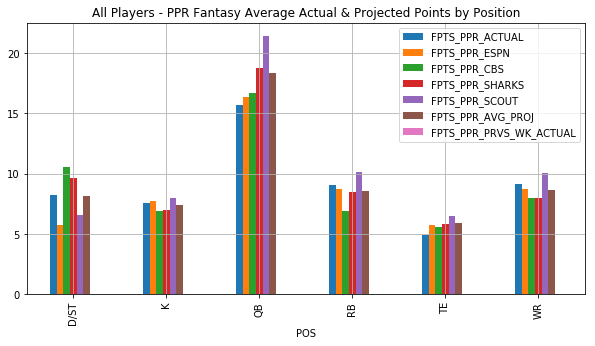

In [34]:
#use groupby to split by position and take AVERAGE 
df_week1_ppr.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL'].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='All Players - PPR Fantasy Average Actual & Projected Points by Position');

In [35]:
### JUST USE AVERAGE INSTEAD OF THIS MEDIAN - SINCE OUR 360 PLAYER LIST ALREADY FILTERED OUT
### ZERO PLAYERS, MEDIAN DOESN'T CHANGE THINGS MUCH BECAUSE LESS OUTLIERS
# #use groupby to split by position and take MEDIAN (see how that compares for outliers)
# df_week1_ppr.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                             'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
#                             'FPTS_PPR_PRVS_WK_ACTUAL'].median().plot.bar(
#                                 figsize = (10,5),
#                                 grid = True,
#                                 title='All Players - PPR Fantasy Median Actual & Projected Points by Position');

##### Look at just Top 10  of each position (top 10 actual and top 10 projected average)

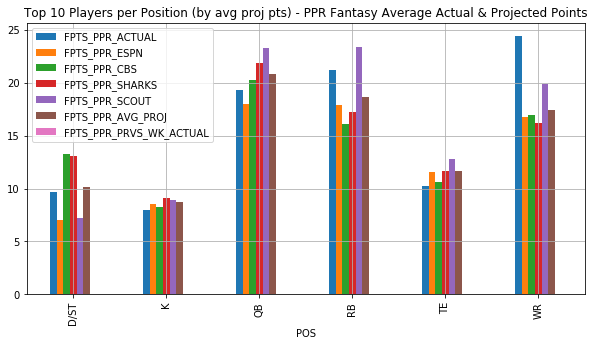

In [36]:
###TRY RANKED BY TOP 10 AVG PROJECTIONS

#first sort dataframe descending by actual fantasy points
#then groubpy position and only take the top 10 players in each position
#creates a new dataframe we can then perform means on by position
df_top_10_proj = df_week1_ppr.sort_values('FPTS_PPR_AVG_PROJ', ascending=False).groupby('POS').head(10)

#now on this reduced dataframe perform groupby position, mean, and graph
df_top_10_proj.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL'].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='Top 10 Players per Position (by avg proj pts) - PPR Fantasy Average Actual & Projected Points');

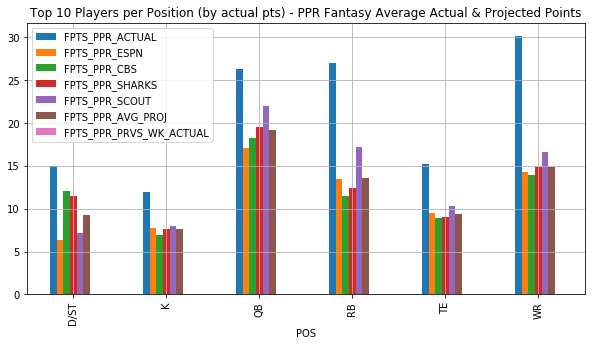

In [37]:
#first sort dataframe descending by actual fantasy points
#then groubpy position and only take the top 10 players in each position
#creates a new dataframe we can then perform means on by position
df_top_10 = df_week1_ppr.sort_values('FPTS_PPR_ACTUAL', ascending=False).groupby('POS').head(10)

#now on this reduced dataframe perform groupby position, mean, and graph
df_top_10.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL'].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='Top 10 Players per Position (by actual pts) - PPR Fantasy Average Actual & Projected Points');

##### Then Look at Top 11-32 (ranked by average projections) of each position

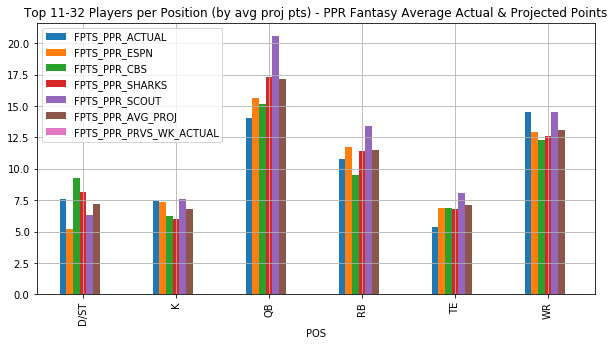

In [38]:
###TRY RANKED BY TOP 11-32 AVG PROJECTIONS

#first sort dataframe descending by actual fantasy points
#take head of 32, then take the tail 22 of that subset
#creates a new dataframe we can then perform means on by position
df_top_11_32_proj = df_week1_ppr.sort_values('FPTS_PPR_AVG_PROJ', ascending=False).groupby('POS').head(32).groupby('POS').tail(22)

#now on this reduced dataframe perform groupby position, mean, and graph
df_top_11_32_proj.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL'].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='Top 11-32 Players per Position (by avg proj pts) - PPR Fantasy Average Actual & Projected Points');

##### Then Look at Top 33-64 (ranked by average projections) of RB, WR, TE (other positions typically only have 32 in DB)

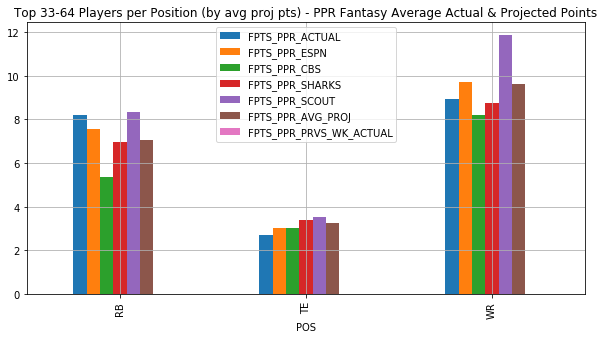

In [39]:
###TRY RANKED BY TOP 33-64 AVG PROJECTIONS

#filter to RB/WR/TE
df_rb_wr_te = df_week1_ppr[df_week1_ppr['POS'].isin(['RB', 'WR', 'TE'])]

#first sort dataframe descending by actual fantasy points
#take head of 64, then take the tail 32 of that subset
#creates a new dataframe we can then perform means on by position
df_top_33_64_proj = df_rb_wr_te.sort_values('FPTS_PPR_AVG_PROJ', ascending=False).groupby('POS').head(64).groupby('POS').tail(32)

#now on this reduced dataframe perform groupby position, mean, and graph
df_top_33_64_proj.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL'].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='Top 33-64 Players per Position (by avg proj pts) - PPR Fantasy Average Actual & Projected Points');

##### Then Look at 64 - 96 (ranked by average projections) of RB, WR (other positions typically don't have more than 64 in DB)

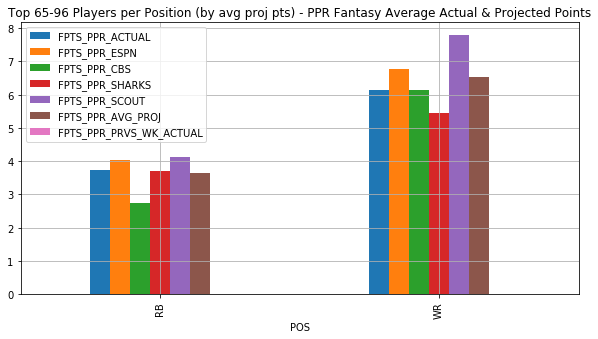

In [40]:
###TRY 65-96 AVG PROJECTIONS

#filter to RB/WR
df_rb_wr = df_week1_ppr[df_week1_ppr['POS'].isin(['RB', 'WR'])]

#first sort dataframe descending by actual fantasy points
#take head of 96, then take the tail 32 of that subset
#creates a new dataframe we can then perform means on by position
df_top_65_96_proj = df_rb_wr.sort_values('FPTS_PPR_AVG_PROJ', ascending=False).groupby('POS').head(96).groupby('POS').tail(32)

#now on this reduced dataframe perform groupby position, mean, and graph
df_top_65_96_proj.groupby('POS')['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
                            'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_AVG_PROJ',
                            'FPTS_PPR_PRVS_WK_ACTUAL'].mean().plot.bar(
                                figsize = (10,5),
                                grid = True,
                                title='Top 65-96 Players per Position (by avg proj pts) - PPR Fantasy Average Actual & Projected Points');

In [41]:
# ### OLD FUNCTION / CALCULATION - USE GROUPBY INSTEAD ###
# #df_input = dataframe, pos=position string, top_x_start=integer of top place to include (not 0th index), top_x_end=integer of bottom place to inlcude (not 0th index)
# def get_pos_top_x_mean(df_input, pos, top_x_start, top_x_end):
#     #get df of top_x
#     df_top_x = df_input[df_input['POS'] == pos].sort_values('FPTS_PPR_ACTUAL', ascending=False)[(top_x_start-1):top_x_end]
    
#     #calculate mean on top_x and take only columns we want
#     mean = df_top_x.mean()[['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                             'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']]
    
#     mean_labels = ['FPTS_PPR_ACTUAL', 'FPTS_PPR_ESPN', 'FPTS_PPR_CBS',
#                   'FPTS_PPR_SHARKS', 'FPTS_PPR_SCOUT', 'FPTS_PPR_PRVS_WK_ACTUAL']
    
#     return mean, mean_labels

# qb_top_10, qb_top_10_labels = get_pos_top_x_mean(df_week1_ppr, 'QB', 1, 10)
# rb_top_10, rb_top_10_labels = get_pos_top_x_mean(df_week1_ppr, 'RB', 1, 10)
# wr_top_10, wr_top_10_labels = get_pos_top_x_mean(df_week1_ppr, 'WR', 1, 10)
# te_top_10, te_top_10_labels = get_pos_top_x_mean(df_week1_ppr, 'TE', 1, 10)
# k_top_10, k_top_10_labels = get_pos_top_x_mean(df_week1_ppr, 'K', 1, 10)
# dst_top_10, dst_top_10_labels = get_pos_top_x_mean(df_week1_ppr, 'D/ST', 1, 10)

In [42]:
# ### PLOTLY GROUPED BAR CHART ###
# #grouped bar chart
# trace1 = go.Bar(
#     x=qb_top_10_labels,
#     y=qb_top_10,
#     name='QB Top 10'
# )

# # data = [trace1, trace2]
# # layout = go.Layout(
# #     barmode='group'
# # )

# # fig = go.Figure(data=data, layout=layout)
# # py.iplot(fig, filename='grouped-bar')

# data = [trace1]
# layout = go.Layout(
#     barmode='group'
# )

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='grouped-bar')

# # data = [trace1, trace2]
# # layout = go.Layout(
# #     barmode='group'
# # )

# # fig = go.Figure(data=data, layout=layout)
# # py.iplot(fig, filename='grouped-bar')

In [43]:
# ### EXAMPLE PANDAS READ SQL QUERY STATEMENT WRITTEN LIKE SQL CODE ###
# # just need to establish connection to database through whatever means required

# stmt = """
#     SELECT [STUDENT_ID]
#           ,[PERMNUM]
#           ,[FIRST_NAME]
#           ,[LAST_NAME]
#           ,[GENDER]
#           ,[Ethnicity]
#           ,[SCHOOL_NUMBER]
#           ,[SCHOOL_YEAR]
#           ,[GRADE_NAME]
#           ,[ENTER_DATE]
#           ,[ENTER_CODE]
#           ,[LEAVE_DATE]
#           ,[LEAVE_CODE]
#           ,[RETENTION_IND]
#           ,[ELL_Status]
#           ,[ReadingPB]
#           ,[MathPB]
#           ,[Sped]
#           FROM [dbo].[Demographic Grouping View_2018]"""

# df = pd.read_sql_query(stmt, conn)

In [44]:
# ### EXAMPLE SNIPPETS FROM BELLY BUTTON FLASK APP HOMEWORK WEEK 15 HW - USE OF SQLALCHEMY ###

# import sqlalchemy
# from sqlalchemy.ext.automap import automap_base
# from sqlalchemy.orm import Session
# from sqlalchemy import create_engine

# from flask import Flask, jsonify, render_template
# from flask_sqlalchemy import SQLAlchemy

# app = Flask(__name__)


# #################################################
# # Database Setup
# #################################################

# app.config["SQLALCHEMY_DATABASE_URI"] = "sqlite:///db/bellybutton.sqlite"
# db = SQLAlchemy(app)

# # reflect an existing database into a new model
# Base = automap_base()
# # reflect the tables
# Base.prepare(db.engine, reflect=True)

# # Save references to each table
# Samples_Metadata = Base.classes.sample_metadata
# Samples = Base.classes.samples

# #################################################
# # App Routes Below (not shown, just differnt sqlalchemy query info)
# #################################################

# # Use Pandas to perform the sql query
# stmt = db.session.query(Samples).statement
# df = pd.read_sql_query(stmt, db.session.bind)

# #write query with filters
# sel = [
#         Samples_Metadata.sample,
#         Samples_Metadata.ETHNICITY,
#         Samples_Metadata.GENDER,
#         Samples_Metadata.AGE,
#         Samples_Metadata.LOCATION,
#         Samples_Metadata.BBTYPE,
#         Samples_Metadata.WFREQ,
#     ]

# results = db.session.query(*sel).filter(Samples_Metadata.sample == sample).all()


In [45]:
# ### EXAMPLE SNIPPETS FROM SLQALCHEMY HAWAII CLIMATE HOMEWORK WEEK 11 ###

# import pandas as pd
# import numpy as np
# from sqlalchemy.orm import Session
# from sqlalchemy import create_engine, inspect, func
# from sqlalchemy.ext.automap import automap_base
# from datetime import datetime, timedelta
# from matplotlib import style
# style.use('fivethirtyeight')
# import matplotlib.pyplot as plt


# engine = create_engine('sqlite:///raw_data/hawaii.sqlite')
# Base = automap_base()
# Base.prepare(engine, reflect=True)
# session = Session(bind=engine)
# inspector = inspect(engine)

# # Visual Schema - verify the database has the info we are expecting
# for table_name in inspector.get_table_names():
#     for column in inspector.get_columns(table_name):
#         print(table_name, column.get('name'), column.get('type'))
#     print()
    
# Measurement = Base.classes.hawaii_measurements
# Station = Base.classes.hawaii_stations